# Projeto Airbnb Rio - Modelo de previsão para novos imóveis no Airbnb

### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de Host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o Host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Objetivo do projeto

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### O que temos disponível, inspirações e créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

Foi utilizado como referência para execução do presente projeto a solução do usuário Allan Bruno do kaggle no Notebook: https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb

Você vai perceber semelhanças entre a solução desenvolvida aqui e a dele, mas algumas diferenças significativas no processo de construção do projeto foram realizadas.

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês;
- Os preços são dados em reais;
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados.

### Expectativas Iniciais

- Acreditamos que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ;
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos);
- Adicionais/Comodidades podem ter um impacto significativo, visto que há muitos prédios e casas antigas no Rio de Janeiro cadastrados no Airbnb.

### Importar Bibliotecas

In [1]:
import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split
import atexit
from time import time, strftime, localtime
from datetime import timedelta

### Importar e Consolidar Base de Dados

In [2]:
meses = {'jan': 1, 'fev': 2, 'mar': 3, 'abr': 4, 'mai': 5, 'jun': 6, 'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}

caminho_bases = pathlib.Path('dataset')

base_airbnb = pd.DataFrame()

for arquivo in caminho_bases.iterdir():
    nome_mes = arquivo.name[:3]
    mes = meses[nome_mes]
    
    ano = arquivo.name[-8:]
    ano = int(ano.replace('.csv', ''))
        
    df_mes = pd.read_csv(caminho_bases / arquivo.name)  #'/' barra contrária concatena o pathlib com os arquivos existentes
    df_mes['Ano'] = ano
    df_mes['Mes'] = mes
    base_airbnb = pd.concat([base_airbnb, df_mes])

display(base_airbnb)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (62,87) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (61,62,94) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (87) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


id                            listing_url       scrape_id  \
0         14063     https://www.airbnb.com/rooms/14063  20180414160018   
1         17878     https://www.airbnb.com/rooms/17878  20180414160018   
2         24480     https://www.airbnb.com/rooms/24480  20180414160018   
3         25026     https://www.airbnb.com/rooms/25026  20180414160018   
4         31560     https://www.airbnb.com/rooms/31560  20180414160018   
...         ...                                    ...             ...   
34324  38844730  https://www.airbnb.com/rooms/38844730  20190923212307   
34325  38846408  https://www.airbnb.com/rooms/38846408  20190923212307   
34326  38846703  https://www.airbnb.com/rooms/38846703  20190923212307   
34327  38847050  https://www.airbnb.com/rooms/38847050  20190923212307   
34328  38847655  https://www.airbnb.com/rooms/38847655  20190923212307   

      last_scraped                                          name  \
0       2018-04-14                          Living in a Postcard   
1       2018-04-14             Very Nice 2Br - Copacabana - WiFi   
2       2018-04-14              Nice and cozy near Ipanema Beach   
3       2018-04-14     Beautiful Modern Decorated Studio in Copa   
4       2018-04-14              NICE & COZY 1BDR - IPANEMA BEACH   
...            ...                                           ...   
34324   2019-09-24             TRANSAMERICA BARRA DA TIJUCA R IV   
34325   2019-09-24                      Alugo para o Rock in Rio   
34326   2019-09-24  Apt COMPLETO em COPACABANA c/TOTAL SEGURANÇA   
34327   2019-09-24                     Cobertura Cinematografica   
34328   2019-09-24     Quarto em cobertura em frente à praia III   

                                                 summary  \
0      Besides the most iconic's view, our apartment ...   
1      Please note that special rates apply for New Y...   
2      My studio is located in the best  of Ipanema. ...   
3      Our apartment is a little gem, everyone loves ...   
4      This nice and clean 1 bedroom apartment is loc...   
...                                                  ...   
34324  Em estilo contemporâneo, o Transamerica Prime ...   
34325  Confortável apartamento, 2 quartos , sendo 1 s...   
34326  Apartamento quarto e sala COMPLETO para curtas...   
34327                               Cobertura alto nivel   
34328  Quarto em cobertura quadriplex com vista lindí...   

                                                   space  \
0                                                    NaN   
1      - large balcony which looks out on pedestrian ...   
2      The studio is located at Vinicius de Moraes St...   
3      This newly renovated studio (last renovations ...   
4      This nice and clean 1 bedroom apartment is loc...   
...                                                  ...   
34324                                                NaN   
34325  O apartamento estará com mobília completa disp...   
34326  Espaço ideal para até 5 pessoas. Cama de casal...   
34327                                                NaN   
34328                                                NaN   

                                             description experiences_offered  \
0      Besides the most iconic's view, our apartment ...                none   
1      Please note that special rates apply for New Y...                none   
2      My studio is located in the best  of Ipanema. ...                none   
3      Our apartment is a little gem, everyone loves ...                none   
4      This nice and clean 1 bedroom apartment is loc...                none   
...                                                  ...                 ...   
34324  Em estilo contemporâneo, o Transamerica Prime ...                none   
34325  Confortável apartamento, 2 quartos , sendo 1 s...                none   
34326  Apartamento quarto e sala COMPLETO para curtas...                none   
34327                               Cobertura alto nivel         

### Se tivermos muitas colunas, já vamos identificar quais colunas podemos excluir

- Como temos muitas colunas, nosso modelo pode acabar ficando muito lento.
- Além disso, uma análise rápida permite ver que várias não são necessárias para o nosso modelo de previsão, por isso, vamos excluir algumas colunas da nossa base de dados.
- Tipos de colunas que vamos excluir:
    1. ID, links e informações não relevantes paraq o modelo;
    2. Colunas repetidas ou extremamente parecidas com outra (que dão a mesma informação para o modelo. Ex. Data x Ano/Mês);
    3. Colunas preenchidas com texto livre -> Não rodaremos nenhuma análise de palavras ou algo do tipo;
    4. Colunas em que todos ou quase todos os valores são iguais.


- Para isso vamos criar um arquivo no Excel com os 1.000 primeiros registros e fazer uma análise qualitativa.

In [3]:
print(list(base_airbnb.columns))
base_airbnb.head(1000).to_csv('primeiros_registros.csv', sep=';')

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', '

In [4]:
#a solicitação de .value_counts() feita em uma coluna (Series) com dois '[[]]' quer 
#dizer que oque está dentro é considerado uma lista
print(base_airbnb[['host_acceptance_rate']].value_counts())

host_acceptance_rate
100%                    31697
0%                       4744
50%                      3781
99%                      3320
67%                      3140
                        ...  
16%                        22
15%                        21
7%                         20
51%                        18
6%                         11
Length: 100, dtype: int64


In [5]:
#Comparar duas colunas
print((base_airbnb['host_listings_count']==base_airbnb['host_total_listings_count']).value_counts())

True     901750
False       460
dtype: int64


In [6]:
#somar a quantidade de valores vazios de uma coluna
#obs: Se pelo menos 50% dos dados forem vazios, ai a coluna será excluida
print(base_airbnb['square_feet'].isnull().sum())

888162


### Depois da análise qualitativa das colunas, levando em conta os critérios explicados acima, ficamos com as seguintes colunas

In [7]:
colunas = ['host_response_time', 'host_response_rate', 'host_is_superhost', 'host_listings_count', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'is_business_travel_ready', 'cancellation_policy', 'Ano', 'Mes']

#criar um filtro no nosso DF original com base nas colunas que foram selecionadas em nossa análise
base_airbnb = base_airbnb.loc[:, colunas]
display(base_airbnb)

host_response_time host_response_rate host_is_superhost  \
0                     NaN                NaN                 f   
1          within an hour               100%                 t   
2          within an hour               100%                 f   
3          within an hour               100%                 f   
4          within an hour               100%                 t   
...                   ...                ...               ...   
34324      within an hour                93%                 f   
34325                 NaN                NaN                 f   
34326  within a few hours                74%                 f   
34327                 NaN                NaN                 f   
34328  a few days or more                38%                 f   

       host_listings_count   latitude  longitude property_type  \
0                      1.0 -22.946854 -43.182737     Apartment   
1                      2.0 -22.965919 -43.178962   Condominium   
2                      1.0 -22.985698 -43.201935     Apartment   
3                      3.0 -22.977117 -43.190454     Apartment   
4                      1.0 -22.983024 -43.214270     Apartment   
...                    ...        ...        ...           ...   
34324                  0.0 -23.003180 -43.342840     Apartment   
34325                  0.0 -22.966640 -43.393450     Apartment   
34326                 32.0 -22.962080 -43.175520     Apartment   
34327                  0.0 -23.003400 -43.341820     Apartment   
34328                  5.0 -23.010560 -43.363350     Apartment   

             room_type  accommodates  bathrooms  ...  \
0      Entire home/apt             4        1.0  ...   
1      Entire home/apt             5        1.0  ...   
2      Entire home/apt             2        1.0  ...   
3      Entire home/apt             3        1.0  ...   
4      Entire home/apt             3        1.0  ...   
...                ...           ...        ...  ...   
34324  Entire home/apt             4        1.0  ...   
34325  Entire home/apt             4        2.0  ...   
34326  Entire home/apt             5        1.0  ...   
34327  Entire home/apt             4        1.0  ...   
34328     Private room             2        0.0  ...   

       review_scores_cleanliness  review_scores_checkin  \
0                            9.0                    9.0   
1                            9.0                   10.0   
2                           10.0                   10.0   
3                           10.0                   10.0   
4                           10.0                   10.0   
...                          ...                    ...   
34324                        NaN                    NaN   
34325                        NaN                    NaN   
34326                        NaN                    NaN   
34327                        NaN                    NaN   
34328                        NaN                    NaN   

      review_scores_communication review_scores_location review_scores_value  \
0                             9.0                    9.0                 9.0   
1                            10.0                    9.0                 9.0   
2                            10.0                   10.0                 9.0   
3                            10.0                   10.0                 9.0   
4                            10.0                   10.0                 9.0   
...                           ...                    ...                 ...   
34324                         NaN                    NaN                 NaN   
34325                         NaN                    NaN                 NaN   
34326                         NaN                    NaN                 NaN   
34327                         NaN                    NaN                 NaN   
34328                         NaN                    NaN                 NaN   

      instant_bookable is_business_travel_ready          cancellation_policy  

### Tratar Valores Faltando

- Visualizando os dados, percebemos que existte uma grande disparidade de dados faltantes. As colunas com mais de 300.000 valores NaN serão excluídos da análise, pois o preenchimento dessa informações com '0 por exemplo' poderia criar um viés na nossa análise;


- Para as demais colunas, como temos muitos dados (mais de 900.000 linhas) será realizado a exclusão somente das linhas que contenham dados NaN.

In [8]:
#visualização dos dados para verificação da existência de dados NaN
print(base_airbnb.isnull().sum())

host_response_time             401843
host_response_rate             401846
host_is_superhost                 460
host_listings_count               460
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                        1724
bedrooms                          850
beds                             2502
bed_type                            0
amenities                           0
price                               0
security_deposit               421280
cleaning_fee                   313506
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
number_of_reviews                   0
review_scores_rating           448016
review_scores_accuracy         448586
review_scores_cleanliness      448413
review_scores_checkin          448650
review_score

In [9]:
for coluna in base_airbnb:
    if base_airbnb[coluna].isnull().sum() > 300000:
        base_airbnb = base_airbnb.drop(coluna, axis=1)
print(base_airbnb.isnull().sum())
print(base_airbnb.shape)

host_is_superhost            460
host_listings_count          460
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                   1724
bedrooms                     850
beds                        2502
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
Ano                            0
Mes                            0
dtype: int64
(902210, 23)


In [10]:
#Excluindo as linhas das colunas que possuem dados NaN
base_airbnb = base_airbnb.dropna()
print(base_airbnb.isnull().sum())

host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
Ano                         0
Mes                         0
dtype: int64


In [11]:
print(base_airbnb.shape)

(897709, 23)


### Verificar Tipos de Dados em cada coluna

In [12]:
base_airbnb.info()
print('-' * 60)
print(base_airbnb.iloc[0])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 897709 entries, 0 to 34328
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   host_is_superhost         897709 non-null  object 
 1   host_listings_count       897709 non-null  float64
 2   latitude                  897709 non-null  float64
 3   longitude                 897709 non-null  float64
 4   property_type             897709 non-null  object 
 5   room_type                 897709 non-null  object 
 6   accommodates              897709 non-null  int64  
 7   bathrooms                 897709 non-null  float64
 8   bedrooms                  897709 non-null  float64
 9   beds                      897709 non-null  float64
 10  bed_type                  897709 non-null  object 
 11  amenities                 897709 non-null  object 
 12  price                     897709 non-null  object 
 13  guests_included           897709 non-null  in

- como 'price' e 'extra_people' estão sendo reconhecidos como objetos (ao invés de ser um float) temos que mudar o tipo de variável da coluna

In [13]:
#price - inicalmente precisamos tirar o '$' e depois a virgula separadora de milhar
base_airbnb['price'] = base_airbnb['price'].str.replace('$', '', regex=False)
base_airbnb['price'] = base_airbnb['price'].str.replace(',', '', regex=False)

#price - agora usando a bilbioteca Numpy vamos alterar os dados da coluna de objeto para float32 (ocupa menos memória em grandes DF)
base_airbnb['price'] = base_airbnb['price'].astype(np.float32, copy=False)

#extra_people
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '', regex=False)
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(',', '', regex=False)
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32, copy=False)

#verificando os tipos de dados
base_airbnb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 897709 entries, 0 to 34328
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   host_is_superhost         897709 non-null  object 
 1   host_listings_count       897709 non-null  float64
 2   latitude                  897709 non-null  float64
 3   longitude                 897709 non-null  float64
 4   property_type             897709 non-null  object 
 5   room_type                 897709 non-null  object 
 6   accommodates              897709 non-null  int64  
 7   bathrooms                 897709 non-null  float64
 8   bedrooms                  897709 non-null  float64
 9   beds                      897709 non-null  float64
 10  bed_type                  897709 non-null  object 
 11  amenities                 897709 non-null  object 
 12  price                     897709 non-null  float32
 13  guests_included           897709 non-null  in

### Análise Exploratória e Tratar Outliers

- Vamos basicamente olhar feature por feature para:
    
    1. Ver a correlação entre as features (aqui no caso as Colunas, ou características) e decidir se manteremos as features que temos;
    2. Excluir outliers (usaremos o Conceito de Quartil (Estatística)), serão excluidos os valores abaixo de (Q1 - 1.5x Amplitude) e valores acima de (Q3 + 1.5x Amplitude), Amplitude = Q3 - Q1)
    3. Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e se devemos excluir.

- Vamos começar pelas colunas de price (resultado final que queremos) e de extra_people (também valor monetário). Esses são os valores numéricos contínuos;
- Depois vamos analisar as colunas de valores numéricos discretos (accomodates, bedrooms, guests_included, etc.);
- Por fim, vamos analisar as colunas de texto e definir quais categorias fazem sentido mantermos ou não.

MAS CUIDADO: não saia excluindo direto outliers, pense exatamente no que você está fazendo. Se não tem um motivo claro para remover o outlier, talvez não seja necessário e pode ser prejudicial para a generalização. Então tem que ter uma balança ai. Claro que você smpre pode testar e ver qual dá o melhor resultado, mas fazer isso para todas as features vai dar muito trabalho.

Ex. de análise: Se o objetivo é ajudar a precificar um imóvel que você está querendo disponibilizar, excluir outliers em host_listings_count pode fazer sentido. Agora, se você é uma empresa com uma série de propriedades e quer comparar com outras empresas do tipo e também se posicionar dessa forma, talvez excluir quem tem acima de 6 propriedades tire isso do seu modelo. Pense sempre no seu objetivo.

In [14]:
#usaremos inicialmente um método ja existente do Pandas que cria uma correção de cada coluna com cada coluna
print(base_airbnb.corr())

                     host_listings_count  latitude  longitude  accommodates  \
host_listings_count             1.000000 -0.034115   0.063635      0.069320   
latitude                       -0.034115  1.000000   0.370416     -0.142082   
longitude                       0.063635  0.370416   1.000000     -0.121746   
accommodates                    0.069320 -0.142082  -0.121746      1.000000   
bathrooms                       0.022332 -0.169135  -0.170504      0.521909   
bedrooms                        0.039712 -0.165050  -0.186332      0.675913   
beds                            0.042788 -0.113931  -0.110392      0.692740   
price                           0.092306 -0.092437  -0.085526      0.269929   
guests_included                 0.041932 -0.091123   0.049375      0.317563   
extra_people                   -0.031589 -0.041113   0.001723      0.078709   
minimum_nights                 -0.006441 -0.016090  -0.019213      0.024583   
maximum_nights                 -0.000100 -0.001386  

<AxesSubplot:>

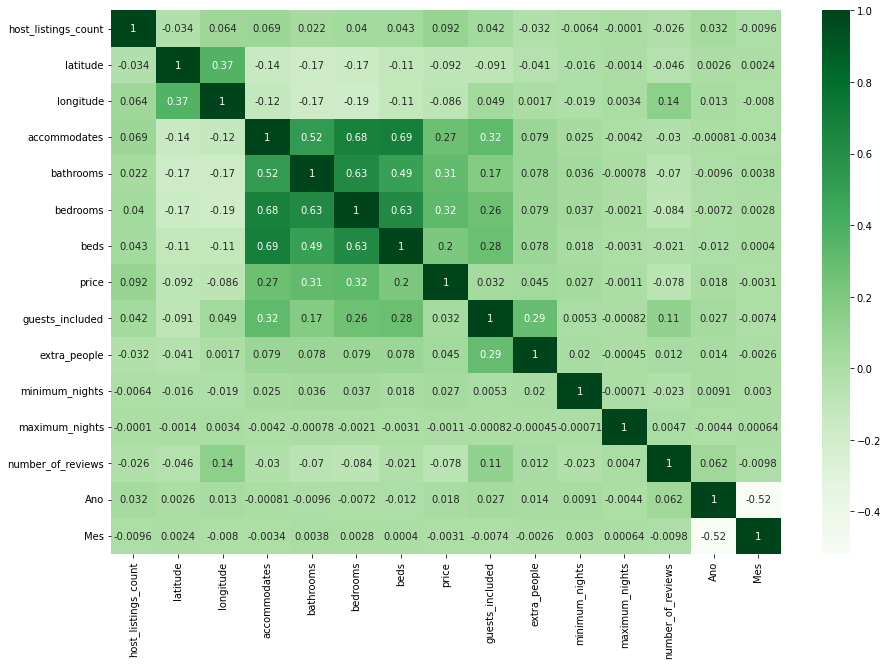

In [15]:
#como o método .corr() imprimi uma tabela dificil de se trabalhar a melhor maneira é
#criando um gráfico de temperatura, utilizando a bibliotgeca Seaborn e Matiplotlib
plt.figure(figsize=(15, 10))
sns.heatmap(base_airbnb.corr(), annot=True, cmap='Greens')

### Definição de funções para Análise de Outliers

Vamos definir algumas funções que irão auxiliar na análise de outliers das colunas

In [16]:
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    limite_inferior = q1 - 1.5 * amplitude
    limite_superior = q3 + 1.5 * amplitude
    return limite_inferior, limite_superior

In [17]:
print(limites(base_airbnb['price']))

#caso queira conferir se a função está correta é só dar um .describe() na coluna 'price'
#e depois apricar a formula com print para verificar
base_airbnb['price'].describe()

(-524.0, 1276.0)


count    897709.000000
mean        648.062195
std        1705.104980
min           0.000000
25%         151.000000
50%         297.000000
75%         601.000000
max      138288.000000
Name: price, dtype: float64

In [18]:
#definindo a function para criação do gráfico de caixa
def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)


In [19]:
#definindo function para excluir outliers e contar quantas linhas foram excluídas
def excluir_outliers(df, nome_coluna):
    qtd_linhas = df.shape[0] #pegando somente a quantidade total de linhas do DF
    lim_inf, lim_sup = limites(df[nome_coluna]) #criando as variáveis limite inf e limite sup
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :] #definindo que seja filtrado as informações entre o limite inf e o limite sup. de todas as colunas
    linhas_removidas = qtd_linhas - df.shape[0] 
    return df, linhas_removidas

In [20]:
#definindo a function para criação do gráfico de histograma
def histograma(coluna):
    plt.figure(figsize=(15, 5))
    #sns.histplot(data=base_airbnb, x=coluna, element='bars')
    sns.distplot(coluna, hist=True)


In [21]:
#definindo uma function para criação de gráfico de barras
def grafico_barras(coluna):
    plt.figure(figsize=(15,5))
    lim_inf, lim_sup = limites(coluna)
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(lim_inf, lim_sup + 4)


### Price - Análise Exploratória

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


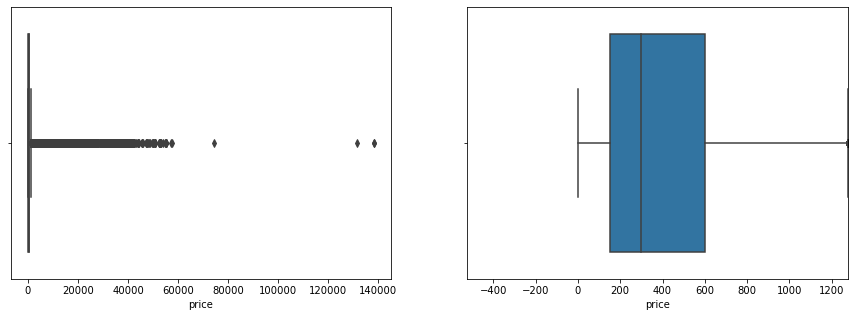

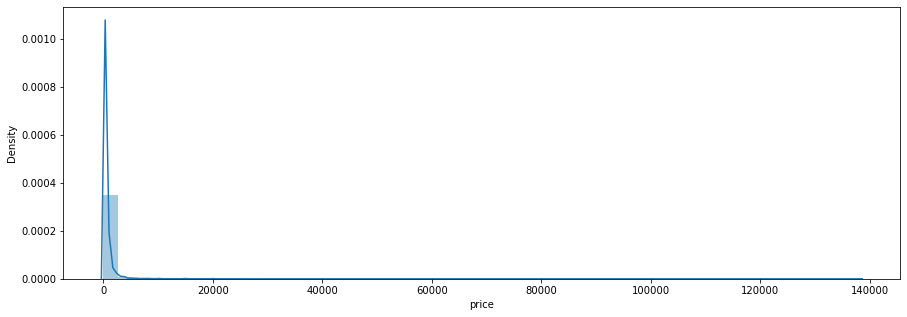

In [22]:
diagrama_caixa(base_airbnb['price'])
histograma(base_airbnb['price'])

- Como estamos construindo um modelo para imóveis comuns, acredito que os valores acima do limite superior serão apenas de imíoveis de alto luxo, o qual não é o nosso objetivo princiapal. Por isso, podemos excluir os outliers (caso a quantidade de outliers são seja muito grande, pois ai teremos que tomar outras medidas par o nosso modelo continuar viável).

In [23]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'price')
print(f'A quantidade de linhas removidas foi: {linhas_removidas}')

A quantidade de linhas removidas foi: 87282


Obs.: A quantidade de linhas removidas chega a quase 10% do total. Mesmo assim vamos continuar essa remoção de linhas, pois o objetivo do projeto aqui é fazer um modelo de previsão de valor de aluguel para imóveis comuns e não para imóveis de alto padrão.

Caso o objetivo fosse elaborar um modelo para imóveis de alto padrão ai seria necessário então manter as outliers. Porém nesse caso o melhor seria elaborar um modelo preditivo para imóveis normais e outro para imóveis de alto padrão tendo em vista que a elaboração de modelo preditivos para ambos os casos não funciona corretamente (somente se o modelo fosse desenvolvido com muita capacidade e expertise, capaciades estas não inerentes ao nosso caso no momento. rsrs!!!)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(810427, 23)


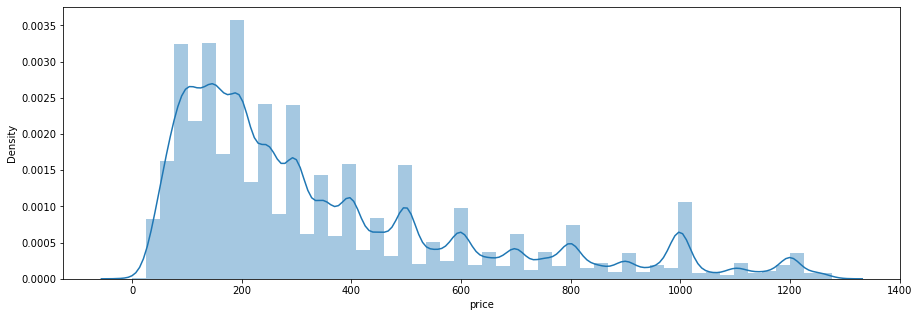

In [24]:
histograma(base_airbnb['price'])
print(base_airbnb.shape)

É possível identificar no histograma acima que os picos acontecem em sua maioria em preços cheios (ex.: 200, 300, 600, 800) isso se deve a questão de como são os proprietários que definem o preço da diária do imóvel, as pessoas raramente vão pensar em valores quebrados, por isso os picos demonstrados no gráfico quando o valor é inteiro.

### Extra_People - Análise Exploratória

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


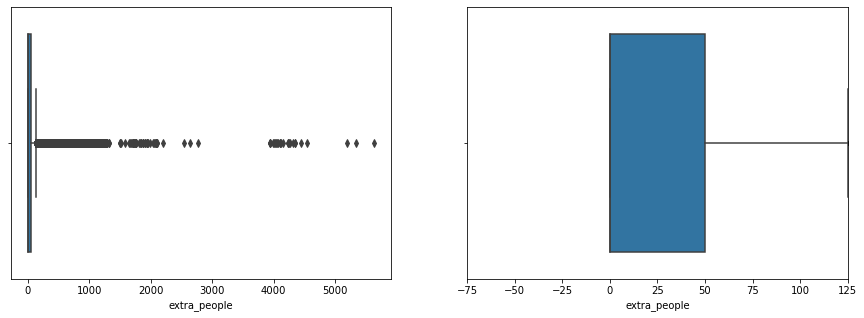

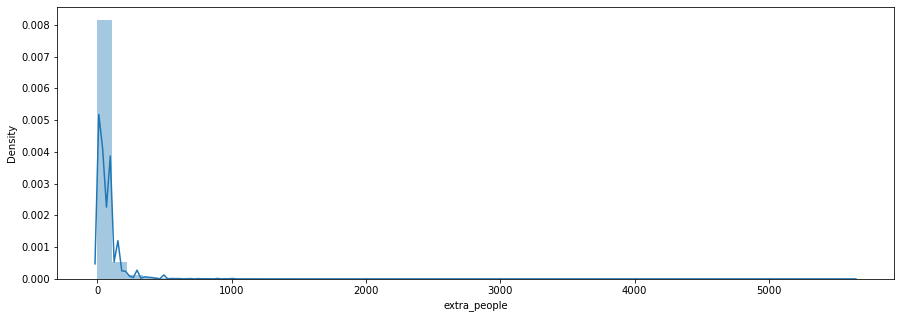

In [25]:
diagrama_caixa(base_airbnb['extra_people'])
histograma(base_airbnb['extra_people'])

In [26]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'extra_people')
print(f'A quantidade de linhas removidas foi: {linhas_removidas}')

A quantidade de linhas removidas foi: 59194


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(751233, 23)


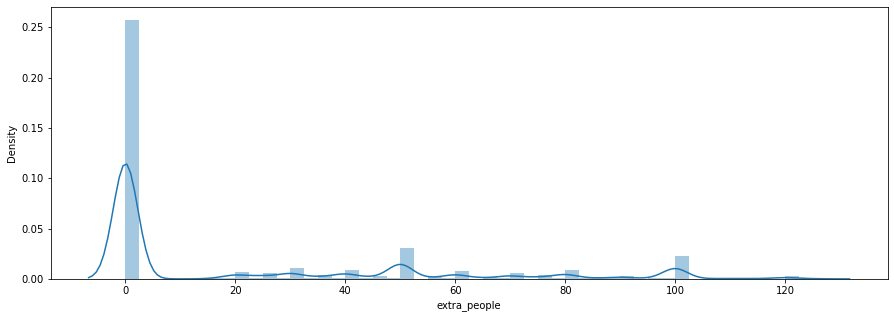

In [27]:
histograma(base_airbnb['extra_people'])
print(base_airbnb.shape)

### Números Discretos - Análise Exploratória

- Host_listings_count

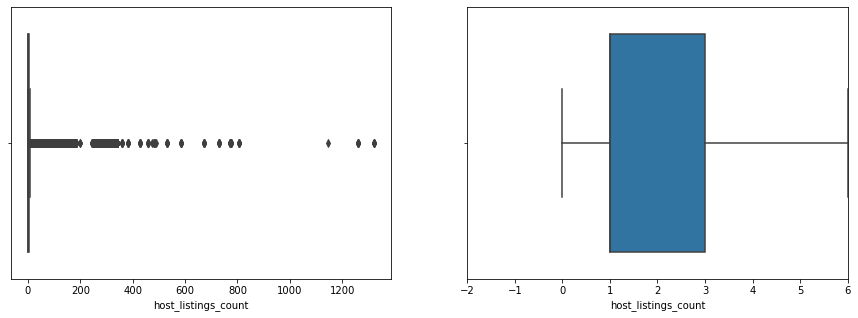

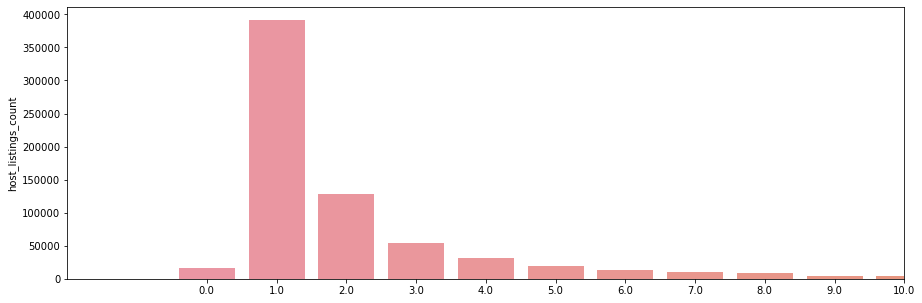

In [28]:
diagrama_caixa(base_airbnb['host_listings_count'])
grafico_barras(base_airbnb['host_listings_count'])

Podemos excluir os Outliers pois o objetivo do presente projeto porque Hosts com mais de 6 imóveis no Airbnb não é público alvo do projeto (imaginamos que Hosts com mais de 6 imóveis sejam imobiliárias ou profissionais que gerenciam imóveis no Airbnb).

In [29]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'host_listings_count')
print(f'A quantidade de linhas removidas foi: {linhas_removidas}')

A quantidade de linhas removidas foi: 97723


- Accommodates

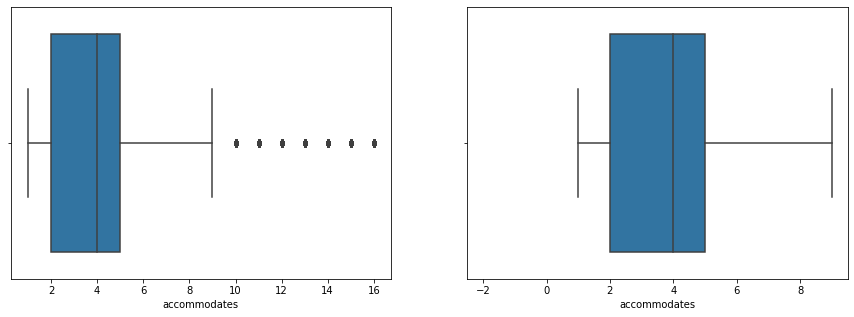

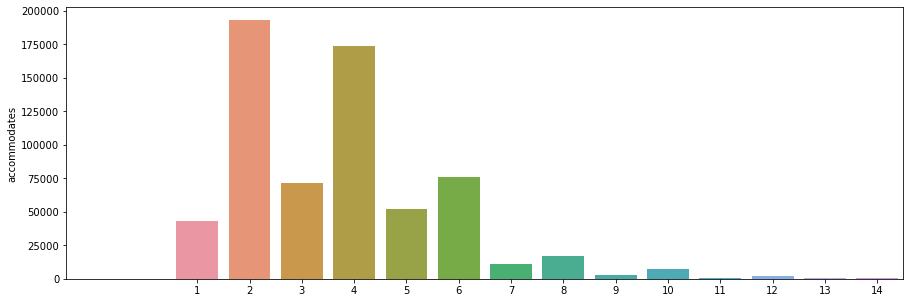

In [30]:
diagrama_caixa(base_airbnb['accommodates'])
grafico_barras(base_airbnb['accommodates'])

Uma casa com possibilidade de acomodar mais de 9 pessoas também não entra na nossa análise como uma casa padrão, logo mesmo podendo deixar os Outliers por serem poucos, vamos seguir a mesma metodologia e excluí-los.

In [31]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'accommodates')
print(f'A quantidade de linhas removidas foi: {linhas_removidas}')

A quantidade de linhas removidas foi: 13146


- Bathrooms

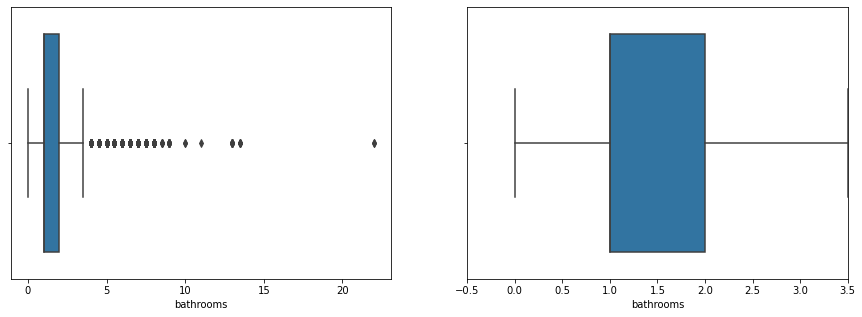

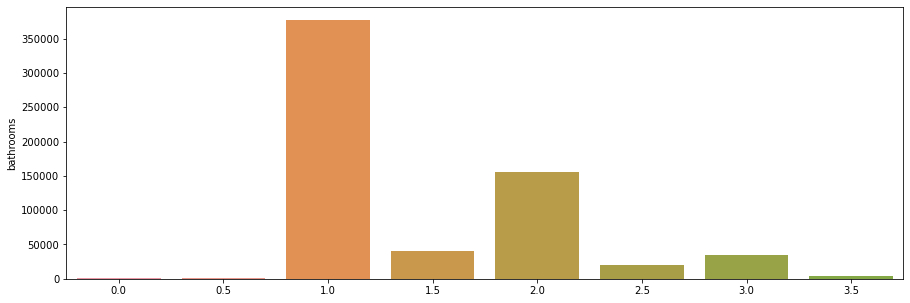

In [32]:
diagrama_caixa(base_airbnb['bathrooms'])
grafico_barras(base_airbnb['bathrooms'])

In [33]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bathrooms')
print(f'A quantidade de linhas removidas foi: {linhas_removidas}')

A quantidade de linhas removidas foi: 6894


- Bedrooms

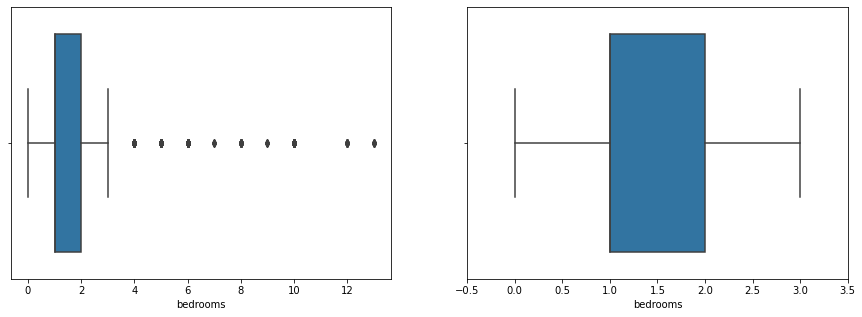

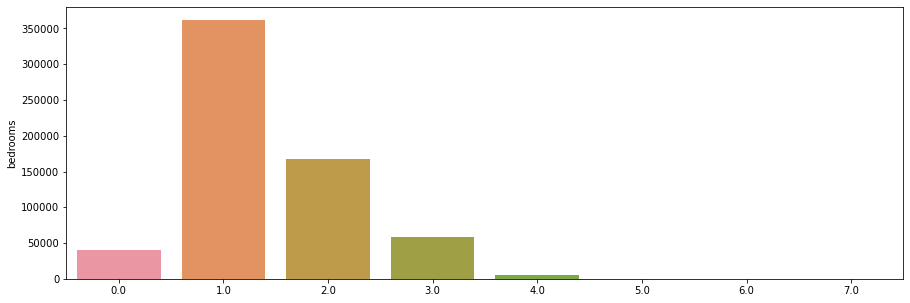

In [34]:
diagrama_caixa(base_airbnb['bedrooms'])
grafico_barras(base_airbnb['bedrooms'])

In [35]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bedrooms')
print(f'A quantidade de linhas removidas foi: {linhas_removidas}')

A quantidade de linhas removidas foi: 5482


- Beds

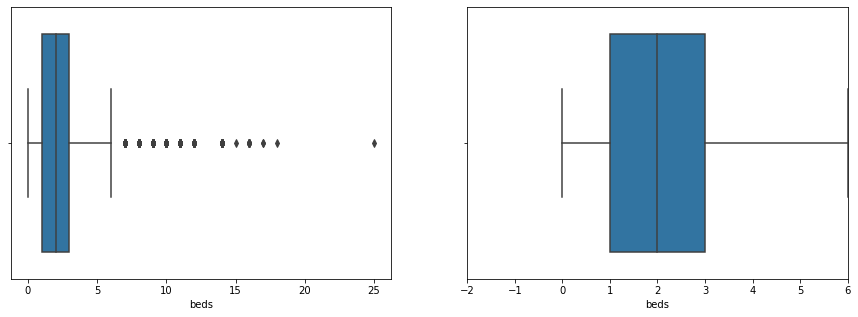

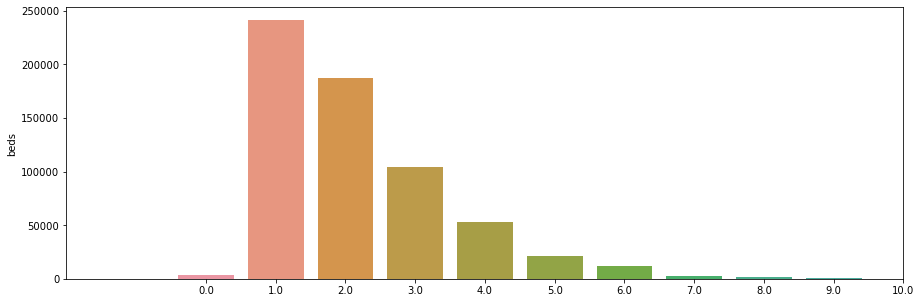

In [36]:
diagrama_caixa(base_airbnb['beds'])
grafico_barras(base_airbnb['beds'])

In [37]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'beds')
print(f'A quantidade de linhas removidas foi: {linhas_removidas}')

A quantidade de linhas removidas foi: 5622


- Guests_included

(1.0, 1.0)


<AxesSubplot:ylabel='guests_included'>

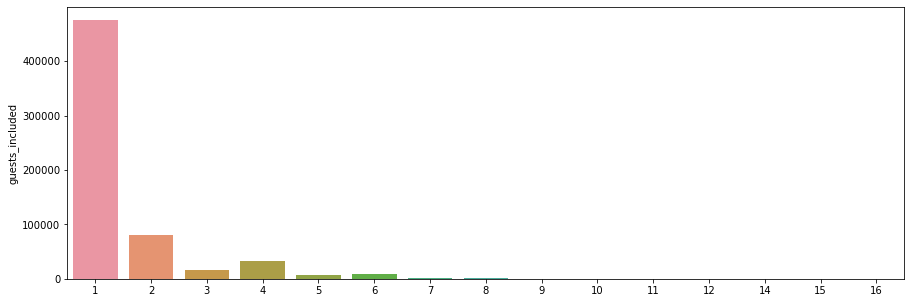

In [38]:
diagrama_caixa(base_airbnb['guests_included'])
grafico_barras(base_airbnb['guests_included'])
print(limites(base_airbnb['guests_included']))
plt.figure(figsize=(15, 5))
sns.barplot(x=base_airbnb['guests_included'].value_counts().index, y=base_airbnb['guests_included'].value_counts())

Pela análise do gráfico é possível que a maioria dos usuários do Airbnb comete um erro na hora do preenchimento dessa feature 'Guest_included' (que quer dizer pessoas incluidas na diária), ou seja, se o proprietário aluga um imóvel como uma cama de casal, por exemplo, então o porque não colocar que o mínimo seja para duas pessoas. Essa feature pode levar o nosso modelo a considerar uma informação como essencial para definição do rpeço, sendo que ela não é.

Sendo assim não vamos tratar as Outliers e sim vamos excluir essa coluna da nossa análise.

In [39]:
base_airbnb = base_airbnb.drop('guests_included', axis=1)
base_airbnb.shape

(622366, 22)

- Minimum nights

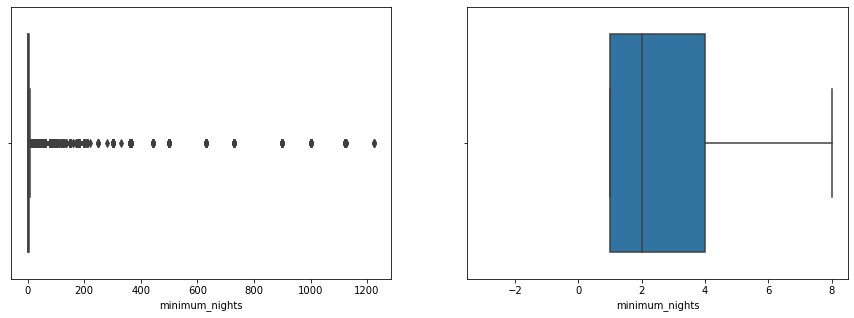

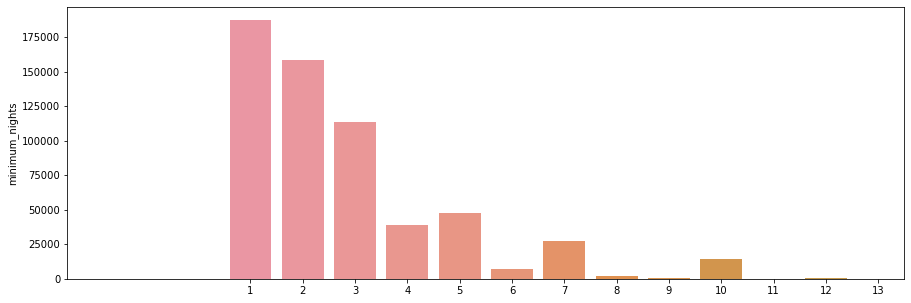

In [40]:
diagrama_caixa(base_airbnb['minimum_nights'])
grafico_barras(base_airbnb['minimum_nights'])

Como no presente projeto, novamente, estamos objetivando definir preço para diárias de um imóvel comum, qualquer quantidade acima de 08 diárias pode ser considerado temporado, logo não é o foco do projeto.

Considerando essa nossa análise, excuir as Outliers é totalmente considerável e será realizado.

In [41]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'minimum_nights')
print(f'A quantidade de linhas removidas foi: {linhas_removidas}')

A quantidade de linhas removidas foi: 40383


- Maximum nights

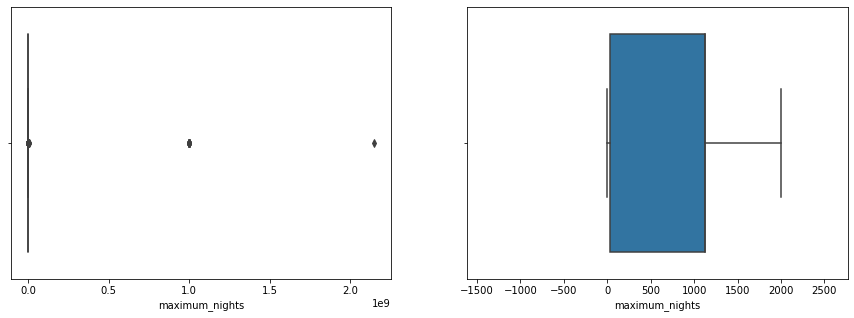

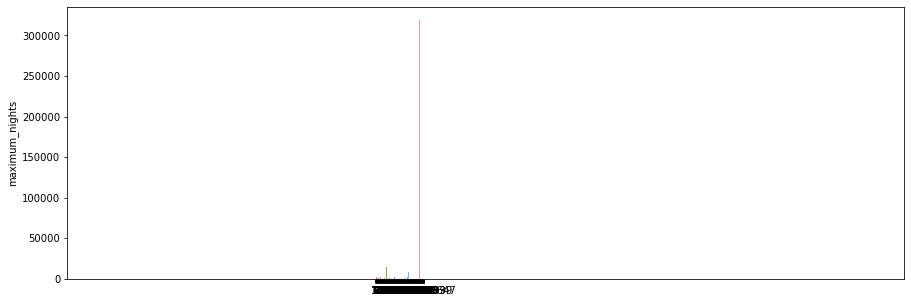

In [42]:
diagrama_caixa(base_airbnb['maximum_nights'])
grafico_barras(base_airbnb['maximum_nights'])

Após a análise dos gráficos acima entendemos que essa feature não está sendo preenchida pelo usuários do Airbnb ou está sendo preenchida com um valor qualquer somente por preencher. Ex.: o Q3 (terceiro quartil) do gráfico está com um limite superior de 2000 diárias, ou seja, quem aluga um imóvel no Airbnb por 2000 diárias.

Sendo assim escolhemos por realizar a exclusão dessa coluna da noss abase de dados também para não influenciar nosso modelo de previsão.

In [43]:
base_airbnb = base_airbnb.drop('maximum_nights', axis=1)
base_airbnb.shape

(581983, 21)

- Number_of_reviews

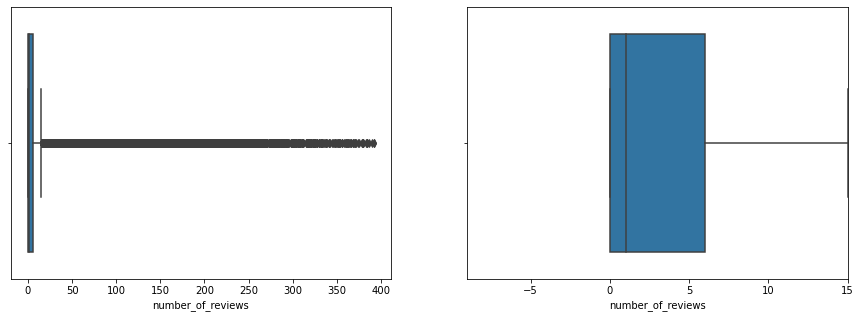

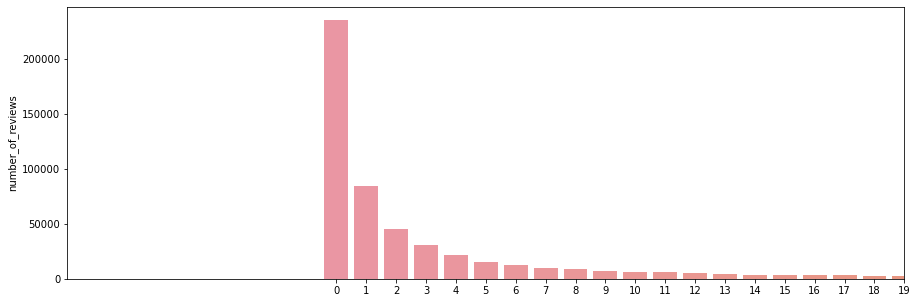

In [44]:
diagrama_caixa(base_airbnb['number_of_reviews'])
grafico_barras(base_airbnb['number_of_reviews'])

Para o presente projeto o objetivo é criar um modelo de precificação para novos usuários ou usuários com poucos aluguéis executados, sendo assim o número de Reviews será bem baixo ou inexistente.... e isso impactará o nosso modelo pois será necessário passar uma métrica de review nulo para o caso de number_of_reviews. 

Em resumo, o nosso modelo será para uma pessoa que não tem review, que não tem imóvel disponibilizado na plataforma e assim poder saber quanto ela tem que cobrar pelo imóvel ao incluí-lo na plataforma.

Sendo assim vamos retirar as outliers e sim vamos tirar essa feature da nossa base de dados.

In [45]:
base_airbnb = base_airbnb.drop('number_of_reviews', axis=1)
base_airbnb.shape

(581983, 20)

### Tratamento de Colunas de Valores de Texto

- Property_type

Apartment                 458354
House                      51387
Condominium                26456
Serviced apartment         12671
Loft                       12352
Guest suite                 3621
Bed and breakfast           3472
Hostel                      2665
Guesthouse                  2155
Other                       1957
Villa                       1294
Townhouse                    969
Aparthotel                   693
Chalet                       481
Earth house                  468
Tiny house                   457
Boutique hotel               447
Hotel                        376
Casa particular (Cuba)       298
Cottage                      230
Bungalow                     207
Dorm                         185
Cabin                        141
Nature lodge                 124
Castle                        80
Treehouse                     76
Island                        54
Boat                          53
Hut                           40
Campsite                      34
Resort    

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


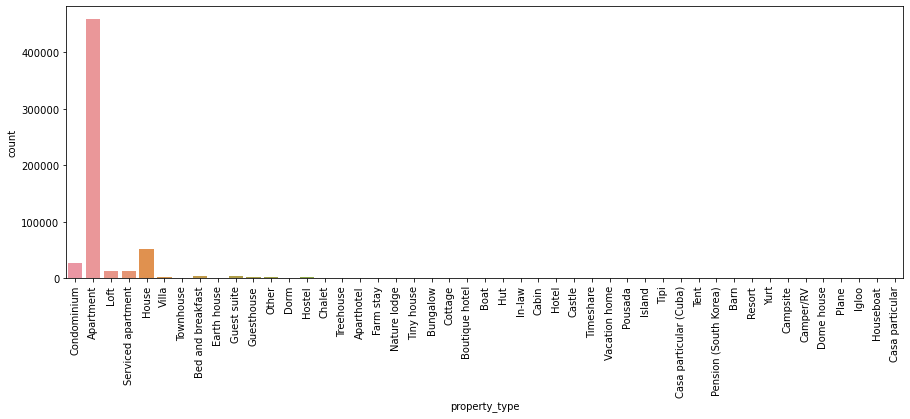

In [46]:
#verificar a quantidade de valores existentes para cada categoria existente na Series,
#para ver se faz sentido analisar cada um de forma separada
print(base_airbnb['property_type'].value_counts())

#verificação das mesma informações só que num gráfico, usando um método do Seaborn
plt.figure(figsize=(15, 5))
grafico = sns.countplot('property_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

Levando em consideração a grande quantidade de categorias dentro da Series 'property_types' e principalmente analisando a quantidade mínimas de algumas dessas categorias, decidimos por realizar um junção das categorias menos relevantes em uma única categora chamada 'Outros' e usaremos como base o todos os valores abaixo de 2000 para isso.

In [47]:
tabela_tipo_outros = base_airbnb['property_type'].value_counts()
coluna_outros = []

for tipo in tabela_tipo_outros.index:
    if tabela_tipo_outros[tipo] < 2000:
        coluna_outros.append(tipo)
print(coluna_outros)

['Other', 'Villa', 'Townhouse', 'Aparthotel', 'Chalet', 'Earth house', 'Tiny house', 'Boutique hotel', 'Hotel', 'Casa particular (Cuba)', 'Cottage', 'Bungalow', 'Dorm', 'Cabin', 'Nature lodge', 'Castle', 'Treehouse', 'Island', 'Boat', 'Hut', 'Campsite', 'Resort', 'Camper/RV', 'Yurt', 'Tent', 'Tipi', 'Barn', 'Farm stay', 'Pension (South Korea)', 'Dome house', 'Igloo', 'In-law', 'Vacation home', 'Timeshare', 'Pousada', 'Houseboat', 'Casa particular', 'Plane']


Apartment             458354
House                  51387
Condominium            26456
Serviced apartment     12671
Loft                   12352
Outros                  8850
Guest suite             3621
Bed and breakfast       3472
Hostel                  2665
Guesthouse              2155
Name: property_type, dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


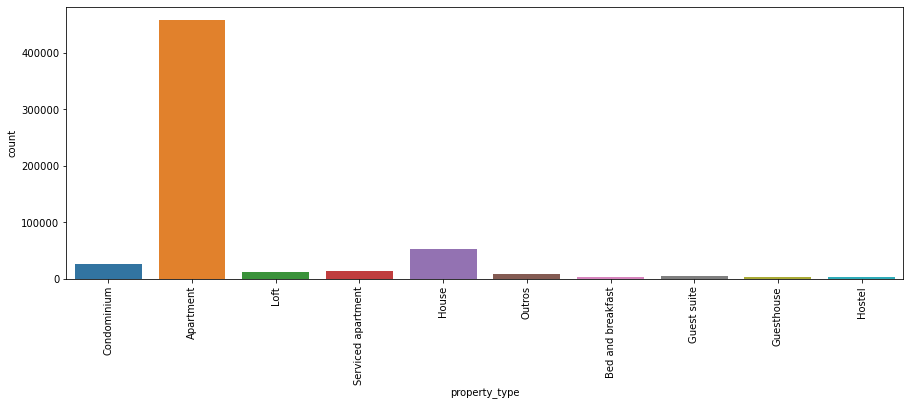

In [48]:
for tipo in coluna_outros:
    #base_airbnb.loc[linha, coluna] = 'nome a agrupar'
    base_airbnb.loc[base_airbnb['property_type']==tipo, 'property_type'] = 'Outros'

print(base_airbnb['property_type'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot('property_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

- Room_type

Entire home/apt    372443
Private room       196859
Shared room         11714
Hotel room            967
Name: room_type, dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


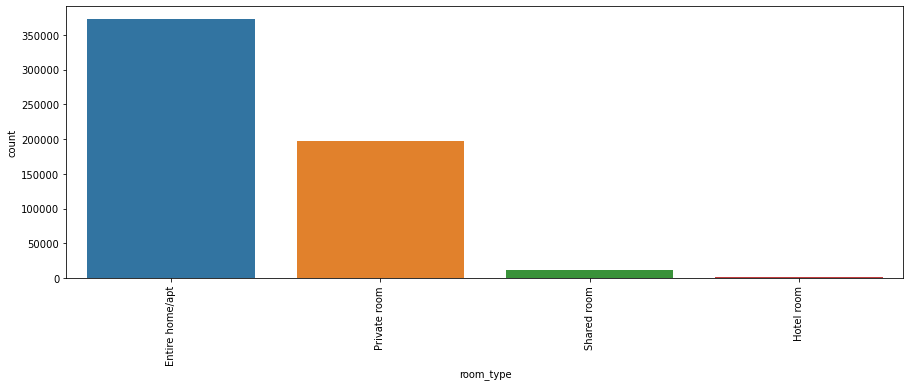

In [49]:
print(base_airbnb['room_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('room_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

- Bed_type

Real Bed         570643
Pull-out Sofa      8055
Futon              1634
Airbed             1155
Couch               496
Name: bed_type, dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


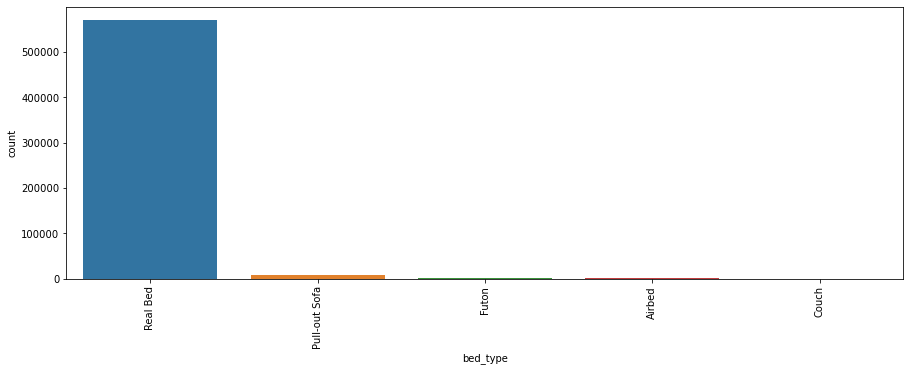

In [50]:
print(base_airbnb['bed_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('bed_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

In [51]:
tabela_cama_outros = base_airbnb['bed_type'].value_counts()
coluna_cama_outros = []

for cama in tabela_cama_outros.index:
    if tabela_cama_outros[cama] < 8060:
        coluna_cama_outros.append(cama)
print(coluna_cama_outros)

['Pull-out Sofa', 'Futon', 'Airbed', 'Couch']


Real Bed    570643
Outras       11340
Name: bed_type, dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


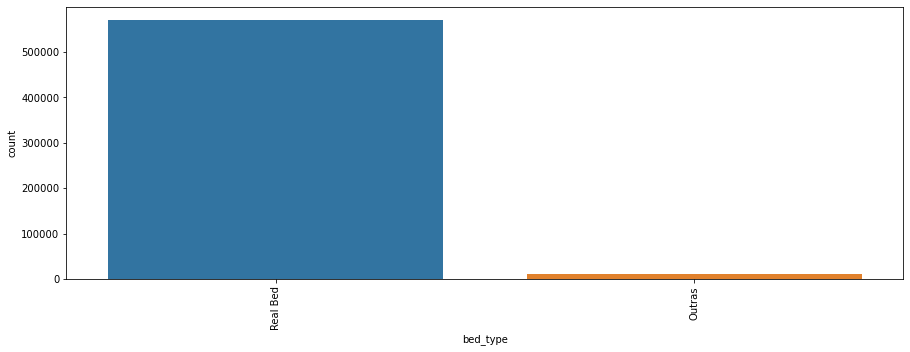

In [52]:
for tipo in coluna_cama_outros:
    #base_airbnb.loc[linha, coluna] = 'nome a agrupar'
    base_airbnb.loc[base_airbnb['bed_type']==tipo, 'bed_type'] = 'Outras'

print(base_airbnb['bed_type'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot('bed_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

- Cancellation_policy

flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9696
super_strict_60                   135
super_strict_30                    32
Name: cancellation_policy, dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


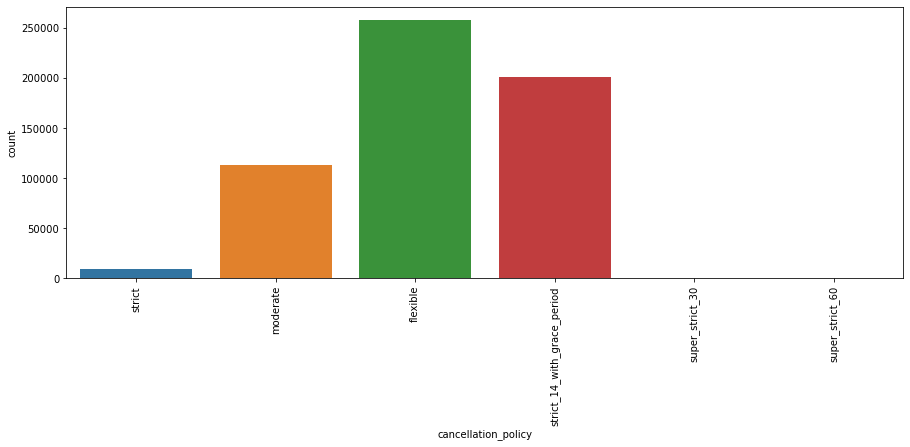

In [53]:
print(base_airbnb['cancellation_policy'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('cancellation_policy', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

In [54]:
tabela_cancellation = base_airbnb['cancellation_policy'].value_counts()
coluna_stricts = []

for tipo in tabela_cancellation.index:
    if tabela_cancellation[tipo] < 9700:
        coluna_stricts.append(tipo)
print(coluna_stricts)

['strict', 'super_strict_60', 'super_strict_30']


flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
Strict                           9863
Name: cancellation_policy, dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


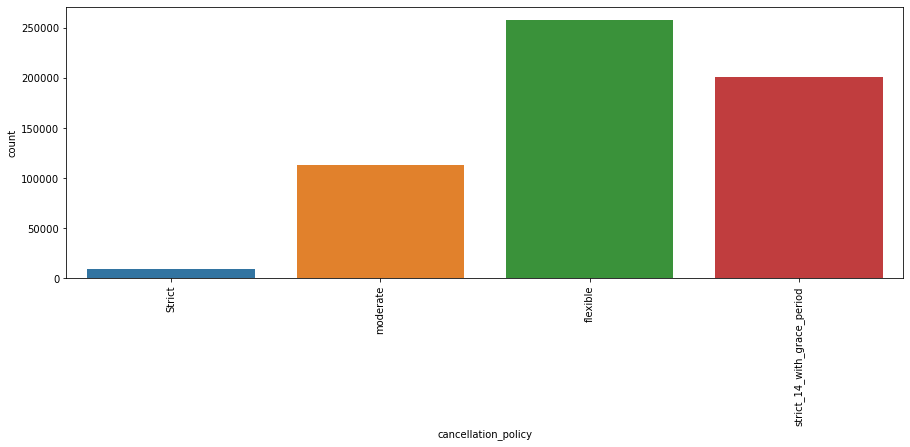

In [55]:
for tipo in coluna_stricts:
    #base_airbnb.loc[linha, coluna] = 'nome a agrupar'
    base_airbnb.loc[base_airbnb['cancellation_policy']==tipo, 'cancellation_policy'] = 'Strict'

print(base_airbnb['cancellation_policy'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot('cancellation_policy', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

- Amenities

Como temos uma diversidade muito grande de Amenities(descrições do imóvel e/ou comodidades existentes para melhor atender o usuário) e, às vezes, as mesmas Amenities podem ser escritas de forma diferente, vamos avaliar a quantidade de Amenities como parâmetro para o nosso modelo.

In [56]:
print(base_airbnb['amenities'].iloc[0].split(','))
print(len(base_airbnb['amenities'].iloc[0].split(',')))

#sempre que vc quiser aplicar uma formula de texto em todos os valores de uma coluna do Pandas utiliza-se um .str.split(',')
#no caso aqui além de aplicar uma fórmula de texto queremos saber o tamanho dela, logo usa-se o .apply(len)
base_airbnb['n_amenities'] = base_airbnb['amenities'].str.split(',').apply(len)

['{TV', '"Cable TV"', 'Internet', 'Wifi', '"Air conditioning"', 'Kitchen', '"Paid parking off premises"', '"Smoking allowed"', 'Doorman', 'Elevator', '"Hot tub"', '"Family/kid friendly"', '"Suitable for events"', 'Essentials', '"24-hour check-in"', 'Hangers', '"Hair dryer"', 'Iron', '"Laptop friendly workspace"', '"Self check-in"', '"Front desk/doorperson"', '"Private entrance"', '"Hot water"', '"Bed linens"', '"Luggage dropoff allowed"}']
25


In [57]:
#agora que ja temos criado uma coluna com a quantidade de Amenities, podemos excluir a coluna original do nosso DF
base_airbnb = base_airbnb.drop('amenities', axis=1)
base_airbnb.shape

(581983, 20)

Como a coluna 'n_amenities' é uma coluna numérica, logo ela é uma coluna igual as demais coluna trabalhadas anteriormente no projeto, sendo assim vamos trata-la igual a uma coluna numérica e trabalhar com os mesmos gráficos anteriores.

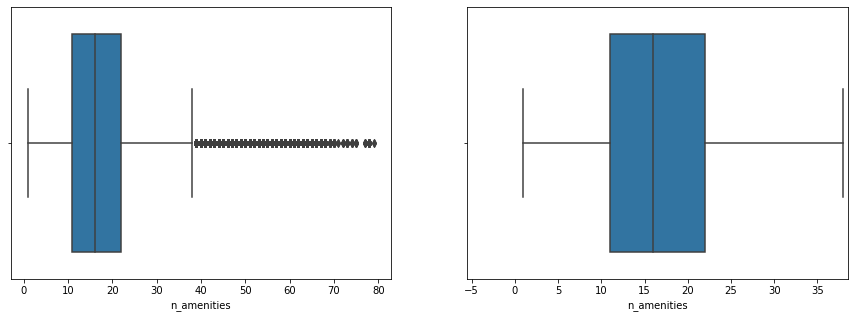

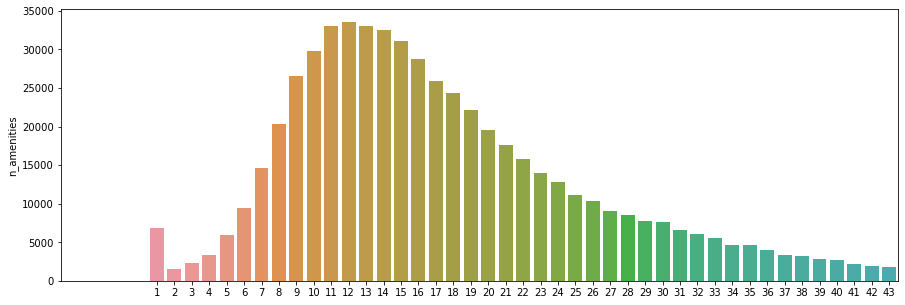

In [58]:
diagrama_caixa(base_airbnb['n_amenities'])
grafico_barras(base_airbnb['n_amenities'])

In [59]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'n_amenities')
print(f'A quantidade de linhas removidas foi: {linhas_removidas}')

A quantidade de linhas removidas foi: 24343


### Visualização de Mapa das Propriedades

In [60]:
amostra = base_airbnb.sample(n=40000)
centro_mapa = {'lat':amostra.latitude.mean(), 'lon':amostra.longitude.mean()}
mapa = px.density_mapbox(amostra, lat='latitude', lon='longitude', z='price', radius=2.5, 
                         center=centro_mapa, zoom = 10, mapbox_style='stamen-terrain')
mapa.show()

### Encoding (o enconding facilita o trabalho do machine learning)

Precisamos ajustar as features para facilitar o trabalho do modelo futuro (features de categoria, true e false, etc.)
- Features de Valores True e False, vamos substituir True por 1 e False por 0;
- Features de Categoria (features em que os valores da coluna são textos) vamos utilizar o método de encondig de variáveis dummies

In [61]:
colunas_booleanas = ['host_is_superhost', 'instant_bookable', 'is_business_travel_ready']

base_airbnb_cod = base_airbnb.copy()

for coluna in colunas_booleanas:
                       #[Linha                      , coluna]
    base_airbnb_cod.loc[base_airbnb_cod[coluna]=='t', coluna] = 1 #transforma todas as linhas com 't' em 1
    base_airbnb_cod.loc[base_airbnb_cod[coluna]=='f', coluna] = 0 #transforma todas as linhas com 'f' em 0


In [62]:
colunas_categorias = ['property_type', 'room_type', 'cancellation_policy', 'bed_type']
#pd.get_dummies() - codifica um dataframe dando como resposta as colunas em Dummies
#parâmetros = data= DF que quer transformar, columns= colocar as colunas que quer transformar em dummies
base_airbnb_cod = pd.get_dummies(data=base_airbnb_cod, columns=colunas_categorias)
display(base_airbnb_cod.head())

host_is_superhost  host_listings_count   latitude  longitude  accommodates  \
1                 1                  2.0 -22.965919 -43.178962             5   
3                 0                  3.0 -22.977117 -43.190454             3   
4                 1                  1.0 -22.983024 -43.214270             3   
5                 1                  1.0 -22.988165 -43.193588             3   
6                 1                  1.0 -22.981269 -43.190457             2   

   bathrooms  bedrooms  beds  price  extra_people  ...  \
1        1.0       2.0   2.0  270.0          51.0  ...   
3        1.0       1.0   2.0  161.0          45.0  ...   
4        1.0       1.0   2.0  222.0          68.0  ...   
5        1.5       1.0   2.0  308.0          86.0  ...   
6        1.0       1.0   2.0  219.0          80.0  ...   

   room_type_Entire home/apt room_type_Hotel room room_type_Private room  \
1                          1                    0                      0   
3                          1                    0                      0   
4                          1                    0                      0   
5                          1                    0                      0   
6                          1                    0                      0   

   room_type_Shared room  cancellation_policy_Strict  \
1                      0                           1   
3                      0                           1   
4                      0                           1   
5                      0                           1   
6                      0                           1   

   cancellation_policy_flexible  cancellation_policy_moderate  \
1                             0                             0   
3                             0                             0   
4                             0                             0   
5                             0                             0   
6                             0                             0   

   cancellation_policy_strict_14_with_grace_period  bed_type_Outras  \
1                                                0                0   
3                                                0                0   
4                                                0                0   
5                                                0                0   
6                                                0                0   

   bed_type_Real Bed  
1                  1  
3                  1  
4                  1  
5                  1  
6                  1  

[5 rows x 36 columns]

### Modelo de Previsão

- Métricas de Avaliação

In [63]:
def avaliar_modelo(nome_modelo, y_teste, previsao):
    r2 = r2_score(y_teste, previsao)
    RSME = np.sqrt(mean_squared_error(y_teste, previsao))
    return f'Modelo {nome_modelo}:\nR²:{r2:.2%}\nRSME:{RSME:.2f}'

- Escolhas dos modelos a serem testados
    1. Random Forest
    2. Linear Regression
    3. Extra Tree

In [64]:
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()
modelo_et = ExtraTreesRegressor()

modelos = {'RandomForest': modelo_rf,
          'LinearRegression': modelo_lr,
          'ExtraTrees': modelo_et}

y = base_airbnb_cod['price']
X = base_airbnb_cod.drop('price', axis=1)

- Separa os dados em treino e teste + Treino do Modelo

In [65]:
def secondsToStr(elapsed=None):
    if elapsed is None:
        return strftime('%Y-%m-%d %H:%M:%S', localtime())
    else:
        return str(timedelta(seconds=elapsed))

def log(s, elapsed=None):
    line = '='*40
    print(line)
    print(secondsToStr(),'-',s)
    if elapsed:
        print('Tempo de execução: ', elapsed)
    print(line)
    print()

def endlog():
    end = time()
    elapsed = end-start
    log('Fim do Teste', secondsToStr(elapsed))

#start = time()
#atexit.register(endlog)
#log('Start Program')

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

for nome_modelo, modelo in modelos.items():
    #treinar o modelo
    modelo.fit(X_train, y_train)
    #testar o modelo
    start = time()
    log(nome_modelo)
    previsao = modelo.predict(X_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))
    endlog()

2022-05-30 13:28:34 - RandomForest

Modelo RandomForest:
R²:97.25%
RSME:43.95
2022-05-30 13:28:43 - Fim do Teste
Tempo de execução:  0:00:08.831490

2022-05-30 13:28:45 - LinearRegression

Modelo LinearRegression:
R²:32.70%
RSME:217.54
2022-05-30 13:28:45 - Fim do Teste
Tempo de execução:  0:00:00.331005

2022-05-30 13:36:12 - ExtraTrees

Modelo ExtraTrees:
R²:97.50%
RSME:41.91
2022-05-30 13:36:24 - Fim do Teste
Tempo de execução:  0:00:11.605119



### Análise do Melhor Modelo

- Modelo escolhido como melhor modelo: ExtraTreesRegressor

    Esse foi o modelo com maior valor de R² e ao mesmo tempo o menor valor de RSME. Como não tivemos uma grande diferença de treino e previsão desse modelo com o modelo de RandomForest (que teve resultados próximos de R² e RSME) vamos escolher o Modelo ExtraTrees.
    
    O modelo de regressão lknear não obteve um resultado satisfatório, com valores de R² e RSME muito piores do que os outros dois modelos.
<br>
- Resultados da Métricas de Avaliação do Modelo vencedor:<br>
    Modelo ExtraTrees:<br>
    R²: 97.50%<br>
    RSME: 41.91

### Ajustes e Melhorias no Melhor Modelo

In [67]:
#Para saber quais qual a importância que cada feature teve dentro do nosso modelo
print(modelo_et.feature_importances_)
#Para saber quais feature são cada importância apresentada acima
print(X_train.columns)

[0.01361057 0.03979417 0.10378453 0.10223064 0.07452876 0.06420646
 0.11581076 0.05305847 0.0883562  0.06416678 0.02217212 0.
 0.01129875 0.00471864 0.08859039 0.01274505 0.00126874 0.00518624
 0.00066985 0.00092304 0.00062311 0.00700435 0.0021004  0.00236926
 0.00221861 0.06670586 0.00031783 0.00400753 0.00188603 0.00085035
 0.01939852 0.01230331 0.00763911 0.00271986 0.00273574]
Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'extra_people',
       'minimum_nights', 'instant_bookable', 'is_business_travel_ready', 'Ano',
       'Mes', 'n_amenities', 'property_type_Apartment',
       'property_type_Bed and breakfast', 'property_type_Condominium',
       'property_type_Guest suite', 'property_type_Guesthouse',
       'property_type_Hostel', 'property_type_House', 'property_type_Loft',
       'property_type_Outros', 'property_type_Serviced apartment',
       'room_type_Entire home/apt', 'room_type_Hotel r

In [68]:
#transformando as informações acima numa DF
importancia_features = pd.DataFrame(modelo_et.feature_importances_, X_train.columns)
#colocando o DF em ordem decrescente do maior valor de importância para o menor
#o valor '0' utilizado é o nome da coluna quando criou-se o DF
importancia_features = importancia_features.sort_values(by=0, ascending=False)
display(importancia_features)

0
bedrooms                                         0.115811
latitude                                         0.103785
longitude                                        0.102231
n_amenities                                      0.088590
extra_people                                     0.088356
accommodates                                     0.074529
room_type_Entire home/apt                        0.066706
bathrooms                                        0.064206
minimum_nights                                   0.064167
beds                                             0.053058
host_listings_count                              0.039794
instant_bookable                                 0.022172
cancellation_policy_flexible                     0.019399
host_is_superhost                                0.013611
property_type_Apartment                          0.012745
cancellation_policy_moderate                     0.012303
Ano                                              0.011299
cancellation_policy_strict_14_with_grace_period  0.007639
property_type_House                              0.007004
property_type_Condominium                        0.005186
Mes                                              0.004719
room_type_Private room                           0.004008
bed_type_Real Bed                                0.002736
bed_type_Outras                                  0.002720
property_type_Outros                             0.002369
property_type_Serviced apartment                 0.002219
property_type_Loft                               0.002100
room_type_Shared room                            0.001886
property_type_Bed and breakfast                  0.001269
property_type_Guesthouse                         0.000923
cancellation_policy_Strict                       0.000850
property_type_Guest suite                        0.000670
property_type_Hostel                             0.000623
room_type_Hotel room                             0.000318
is_business_travel_ready                         0.000000

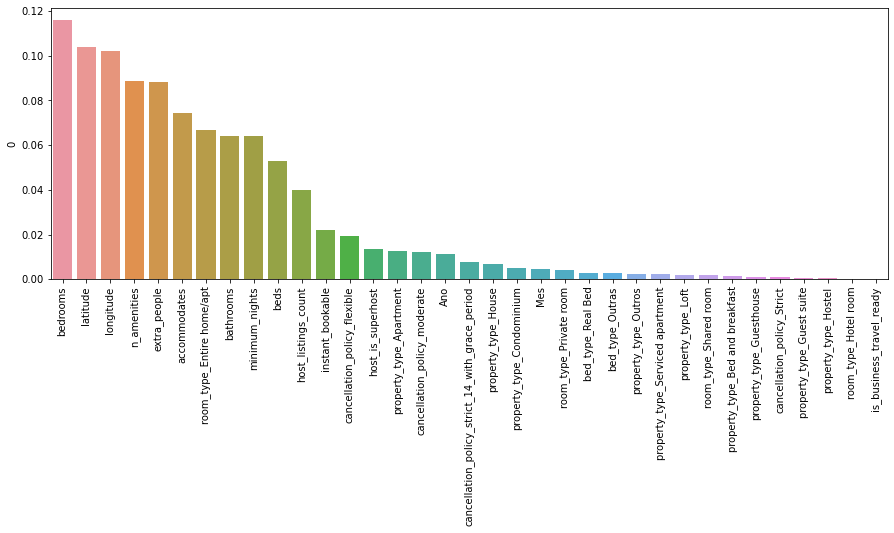

In [69]:
#Criando um gráfico para melhor entender a descrição das importâncias no modelo de ML
plt.figure(figsize=(15,5))
ax = sns.barplot(x=importancia_features.index, y=importancia_features[0])
#A linha de comando abaixo altera o eixo 'X' modificando o sentido do texto
ax.tick_params(axis='x', rotation=90)


### Conclusão:

Analisando o nosso gráfico é possível entender que para o nosso melhor modelo a quantidade de quartos (Bedrooms) foi a feature com maior peso dentro do modelo, porém seguida de muito perto das latitude/ longitude, ou seja, além da quantidade de quartos a localização é extremanente determinante na formação do modelo.

Outra questão muito interessante muito o 'n_amenities' que nada mais é do que a quantidade de descrições feitas pelos Hosts das características e objetos existentes nos imóveis. Isso pode indicar duas coisas, uma que esse imóveis tem mais coisas a oferecer, mais comodidades a oferecer a quem aluga, ou então pode significar que Hosts que fizeram mais e melhores descrições  pode ser um sinal de que o Host é mais atencioso com seu imóvel e consequentemente podem conseguir cobrar mais caro. 

Características como preço por pessoas extras, banheiros existentes, quantidade de pessoas que podem acomodar, mínimo de noite também foram valores decisivos para o modelo na consideração de como elaborar do preço.

O Ano do imóvel foi muito mais relevante do que o mês, ou seja, o ano do imóvel é mais importante para o modelo do que a sazonalidade na definição do preço.


### Observação:

O presente projeto elaborou um modelo de previsão para análises de preço para inclusão de novos imóveis no Airbnb.
Na continuação do projeto será realizado novos ajustes ao modelo para deixá-lo mais simpflificado e com menos tempo de treino/análise.

Em seguida será realizado o deploy do projeto, visnado a criação de uma interface de preenchimento das features de classificação para o usuário final por utilizar o modelo de forma mais simples e intuitiva.

